In [1]:
import networkx as nx
import numpy as np
from random import random
import pandas as pd
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal

In [2]:
G = nx.planted_partition_graph(3, 5, 0.7, 0.05, seed=40)

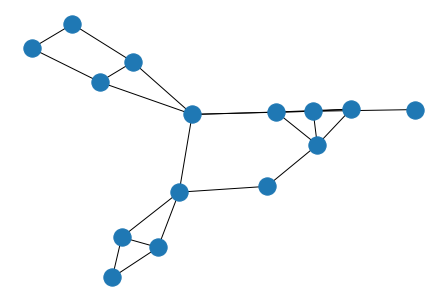

In [3]:
pos = nx.spring_layout(G)
nx.draw(G, pos = pos)

In [4]:
# bigclam algorithm taken from https://github.com/RobRomijnders/bigclam
def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad

def train(A, Att, C, iterations = 100):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C)
    X = Att
    W = np.random.rand(Att.shape[1], C)
    F_new = np.zeros((N,C))
    for n in range(iterations):
        for person in range(N):
            grad = gradient(F, A, person)
            F_new[person] += 0.005*grad + F[person]
            
        Q = np.divide(1, 1 + np.exp(-F.dot(W.T)))
        F_new += 0.005*(X-Q).dot(W)
        F = np.maximum(.001, F_new)
    
    return F

In [5]:
# without node attributes no longer works
#likelihood = []
#preference_matrix = []
#for i in range(100):
    #F, ll = train(A, 3)
    #likelihood.append(ll)
    #preference_matrix.append(F)
#best = np.argmax(likelihood)
#pred = np.argmax(preference_matrix[best], 1)

In [10]:
attr_mat = np.array([np.random.rand(3) for node in G.nodes()])
attr_mat.shape

(15, 3)

In [11]:
A = nx.to_numpy_array(G)
A.shape

(15, 15)

In [8]:
np.argmax(train(A, attr_mat, 3),1)

array([1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0])

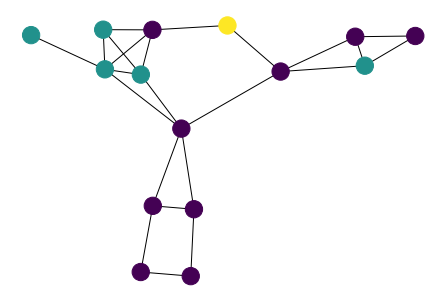

In [34]:
pos = nx.spring_layout(G)
nx.draw(G, pos = pos, node_color=pred)

In [26]:
def bigclam(A, X, K, alpha):
    """
    BigCLAM algorithm for community detection with node features and prior.
    A: adjacency matrix of the graph
    X: node feature matrix
    K: number of communities
    alpha: parameter for the prior probability
    """
    N = A.shape[0] # number of nodes
    F = X.shape[1] # number of features

    # initialize community assignments and feature matrices
    c = np.random.randint(0, K, N)
    mu = np.random.rand(K, F)
    sigma = np.random.rand(K, F)
    count = 0
    max_iter = 100
    # E-step
    while True:
        # compute the prior probability
        prior = np.zeros((N, K))
        for k in range(K):
            mask = (c == k)
            prior[:, k] = np.sum(A[:, mask], axis=1) * alpha
        # compute the likelihood
        likelihood = np.zeros((N, K))
        for k in range(K):
            likelihood[:, k] = multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k])
        # compute the total probability
        probability = likelihood * prior
        probability /= np.sum(probability, axis=1, keepdims=True)

        # check for convergence
        new_c = np.argmax(probability, axis=1)
        if np.array_equal(new_c, c):
            break
        c = new_c
        if count == max_iter:
            break
        count +=1
    return c

In [30]:
attr_mat = np.array([np.random.rand(3) for node in G.nodes()])

In [33]:
pred = bigclam(A, attr_mat, 3, .05)
pred

array([0, 1, 1, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0])

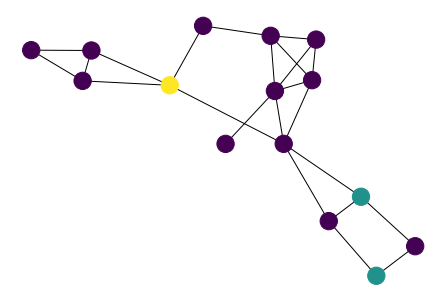

In [32]:
pos = nx.spring_layout(G)
nx.draw(G, pos = pos, node_color=pred)